# DEALING WITH FEW TO NO LABELS

There is one question so deeply ingrained into every data scientist’s mind that it’s usually the first thing they ask at the start of a new project: is there any labeled data? More often than not, the answer is “no” or “a little bit,” followed by an expectation from the client that your team’s fancy machine learning models should still perform well. Since training models on very small datasets does not typically yield good results, one obvious solution is to annotate more data. However, this takes time and can be very expensive, especially if each annotation requires domain expertise to validate.

Fortunately, there are several methods that are well suited for dealing with few to no labels! You may already be familiar with some of them, such as zero-shot or few-shot learning, as witnessed by GPT-3’s impressive ability to perform a diverse range of tasks with just a few dozen examples.

In general, the best-performing method will depend on the task, the amount of available data, and what fraction of that data is labeled. The following decision tree can help us guide us through the process of picking the most appropriate method:

<table>
    <tr>
        <td><img title="" src="images_ch9/decision_tree.PNG" alt="" width="600" data-align="center"></td>
    </tr>
</table>

Let’s walk through this decision tree step-by-step:

1. **Do you have labeled data?** Even a handful of labeled samples can make a difference with regard to which method works best. If you have no labeled data at all, you can start with the zero-shot learning approach, which often sets a strong baseline to work from.
<br></br>
3. **How many labels?** If labeled data is available, the deciding factor is how much. If you have a lot of training data available you can use the standard fine-tuning approach.
<br></br>
1. **Do you have unlabeled data?** If you have a handful of labeled samples it can help immensely if you have access to large amounts of unlabeled data. If you have access to unlabeled data you can either use it to fine-tune the language model on the domain before training the classifier, or you can use more sophisticated methods such as [unsupervised data augmentation (UDA)](https://arxiv.org/abs/1904.12848) or [uncertainty-aware self-training (UST)](https://arxiv.org/abs/2006.15315). If you don't have any unlabaled data available, you don't have the option of annotating more data. In this case you can use few-shot learning or use the embeddings from a pretrained language model to perform lookups with a nearest neighbor search.

In this chapter we'll work our way through this decision tree by tackling a common problem facing many support teams that use issue trackers like Jira and GitHub to assist their users: tagging issues with metadata based on the issue's description. These tags might define the issue type, the product causing the problem, or which team is responsible for handling the reported issue. Automating this process can have a big impact on productivity and enables the support teams to focus on helping their users. As a running example, we'll use the GitHub issues associated with a popular open source project: [🤗 Transformers.](https://github.com/huggingface/transformers)

## 1 - Building a GitHub Issues Tagger

If you navigate to [the Issues tab of the Transformers repository](https://github.com/huggingface/transformers/issues), you'll find issues like the one shown in the following Figure, which contains a title, a description, and a set of tags or labels that characterize the issue. This suggests a natural way to fram the supervised learning task: given a title and description of an issue, predict one or more labels. Since each issue can be assigned a variable number of labels, this means we are dealing with a *multilabel text classification* problem. This is usually more challenging than the multiclass problem where each instance is assigned a single label.

<table>
    <tr>
        <td><img title="" src="images_ch9/example_issue.PNG" alt="" width="600" data-align="center"></td>
    </tr>
</table>

### 1.1 - Getting the data

Now that we have seen what the GitHub issues look like, let's see how we can download them to create our dataset.

To grab all the repositry's issues, we'll use the GitHub REST API to poll the Issues endpoint. This endpoint returns a list of JSON objects, with each containing a large number of fields about the issue at hand, including its state (open or closed), who opened the issue, as well as the title, body, and labels.

Since it takes a while to fetch all the issues, the authors of the book have have included a JSONL file in the book’s GitHub repository with the information. It can be accessed using the following link: https://git.io/nlp-with-transformers

In [2]:
# Note: in 10-10-2024 had to put convert_dates=False cause I was getting floating point error...

import pandas as pd
dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True, convert_dates=False)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


There are almost 10,000 issues in the dataset, and by looking at a single row we can see that the information retrieved from the GitHub API contains many fields such as URLs, IDs, dates, users, title, body, as well as labels:

In [3]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,1617406842000
body,"**[This is not yet alive, preparing for the re..."


The `labels` column is the thing that we’re interested in, and each row contains a list of JSON objects with metadata about each label:
```json
[
    {
        "id":2659267025,
        "node_id":"MDU6TGFiZWwyNjU5MjY3MDI1",
        "url":"https://api.github.com/repos/huggingface...",
        "name":"DeepSpeed",
        "color":"4D34F7",
        "default":false,
        "description":""
    }
]
```

For our purposes, we're only interested in the `name` field of each label object, so let's overwrite the `labels` column with just the label names (i.e., we transform the list of dictionaries into a list of strings)

In [4]:
df_issues["labels"] = (df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


Now each row in the `labels` column is a list of GitHub labels, so we can compute the length of each row to find the number of labels per issue:

In [5]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


This shows that the majority of issues have zero or one label, and much fewer have more than one. Next let's take a look at the top 10 most frequent labels in the dataset. In Pandas we can do this by "exploding" the `labels` column so that each label in the list becomes a row, and then simply counting the occurrences of each label:

In [9]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


We can see that there are 65 unique labels in the dataset and that the classes are very imbalanced, with `wontfix` and `model card` being the most common labels. 

To make the classification problem more tractable, we’ll focus on building a tagger for a subset of the labels. For example, some labels, such as `Good First Issue` or `Help Wanted` , are potentially very difficult to predict from the issue's description, while others, such as `model card`, could be classified with a simple rule that detects when a model card is added on the Hugging Face Hub.

The following code filters the dataset for the subset of labels that we'll work with, along with a standardization of the names to make them easier to read:

In [10]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]
    
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [11]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


Later in this chapter we'll find it useful to treat the unlabeled issues as a separate training split, so let's create a new column that indicates whether the issue is unlabeled or not:

In [12]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


We can see that the number of label occurrences has greatly decreased now, where only a few of the remaining issues have one or more labels.

Let's now take a look at an example:

In [13]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In this example a new model architecture is proposed, so the `new model` tag makes sense. We can also see that the `title` contains information that will be useful for our classifier, so let’s concatenate it with the issue’s description in the `body` field:

In [14]:
df_issues["text"] = (df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

Before we look at the rest of the data, let’s check for any duplicate issues in the data and drop them with the `drop_duplicates()` method:

In [15]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


We can see that there were a few duplicate issues in our dataset, but they only represented a small percentage.

As we’ve done in other chapters, it’s also a good idea to have a quick look at the number of words in our texts to see if we’ll lose much information when we truncate to each model’s context size:

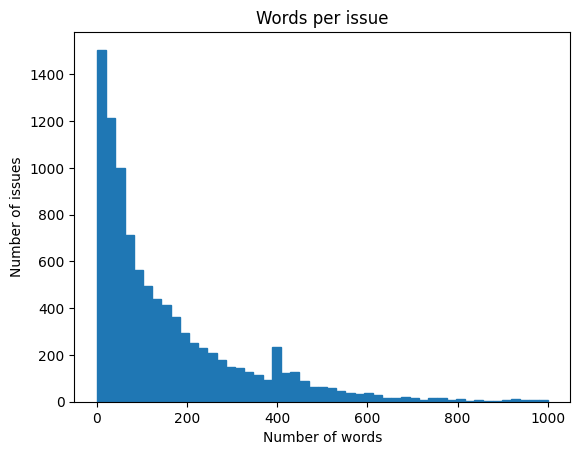

In [16]:
import numpy as np
import matplotlib.pyplot as plt

df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 1000, 50), grid=False, edgecolor="C0")

plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

In [27]:

#Showing one example with the minimum number of words (separated by spaces), 5
df_issues[df_issues["text"].str.split().apply(len) == 5].iloc[0][["title", "text"]]

title                   wav2vec doc tweaks
text     wav2vec doc tweaks\n\ntiny tweaks
Name: 272, dtype: object

In [28]:
(df_issues["text"].str.split().apply(len) > 500).sum()

np.int64(565)

The distribution has the long tail characteristic of many text datasets. Most of the texts are fairly short, but there are also issues with more than 500 words. It is common to have some very long issues, especially when error messages and code snippets are posted along with them.

Given that small transformer models have a context size of around 512 tokens, truncating a handful of long issues in this dataset is not likely to affect the overall performance (only 565 issues have a length higher than 500 words, and even though words $\neq$ tokens, they are usually similar).

### 1.2 - Creating Training Sets

Creating training and validation sets is a bit trickier for multilabel problems because there is no guaranteed balance for all labels. However, it can be approximated, and we can use the [Scikit-multilearn library](https://github.com/scikit-multilearn/scikit-multilearn), which is specifically set up for this purpose.

The first thing we need to do is transform our set of labels, like `pytorch` and `tokenization`, into a format that the model can process. Here we can use [Scikit-learn’s MultiLabel Binarizer class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html), which takes a list of label names and creates a vector with zeros for absent labels and ones for present labels. We can test this by fitting MultiLabel Binarizer on `all_labels` to learn the mapping from label name to ID as follows:

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In this simple example we can see the first row has two ones corresponding to the `tokenization` and `new model` labels, while the second row has just one corresponding to the `pytorch` label.

To create the splits we can use the iterative `train_test_split()` function from Scikit-multilearn, which creates the train/test splits iteratively to achieve balanced labels.

We wrap it in a function that we can apply to DataFrames. Since the function expects a two-dimensional feature matrix, we need to add a dimension to the possible indices before making the split:

* `poetry add scikit-multilearn`

In [34]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
    test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

Armed with the `balanced_split()` function, we can split the data into **supervised** and **unsupervised** datasets, and then create balanced training, validation, and test sets for the supervised part:

In [36]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

Finally, let's create a `DatasetDict` with all the splits so that we can easily tokenize the dataset and integrate with the `Trainer`. Here we'll use the nifty `from_pandas()` method to load each split directly from the corresponding Pandas `DataFrame`:

In [40]:
from datasets import Dataset, DatasetDict
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

This looks good, so the last thing to do is to create some training slices so that we can evaluate the performance of each classifier as a function of the training set size.

### 1.3 - Creating Training Slices

The dataset has the two characteristics that we'd like to investigate in this chapter: 
* Sparse labeled data
* Multilabel classification

The training set consists of only 220 examples, which is certainly a challenge even with transfer learning. To drill down into how each method in this chapter performs with little labeled data, we'll also create slices of the training data with even fewer samples. We can then plot the number of samples against the performance and investigate various regimes. We'll start with only eight samples per label and build up until the slice covers the full training set using the `iterative_train_test_split()` function:

In [41]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
    indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: 
        train_slices.append(new_slice)
    else: 
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))
        
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

Note that this iterative approach only approximately splits the samples to the desired size, since it is not always possible to find a balanced split at a given split size:

In [42]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [44]:
train_slices

[array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,  27,  30,  31,  33,  35,  36,  44,  57,  64,  69,
         73,  74,  78,  80,  90,  91,  99, 105, 123, 136, 141, 152, 180,
        184, 190, 197]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,

We’ll use the specified split sizes as the labels for the following plots.

Now that we have prepared our dataset into training splits, let’s take a look at training a strong baseline model!

## 2 - Implementing a Naive Bayesline

Whenever you start a new NLP project, it is always a good idea to implement a set of strong baselines. There are two main reasons for this:

1. A baseline based on regular expressions, handcrafted rules, on **a very simple model might already work really well to solve the problem**. In these cases, there is no reason to bring out big guns like Transformers, which are generally more complex to deply in production environments.

2. Baselines provide quick checks as you explore more complex models. For example, suppose you train BERT-large and get an accuracy of 80% on your validation set. You might write it off as a hard dataset and call it a day. But what if you knew that a simple classifier like logistic regression gets 95% accuracy? That would raise your suspicions and prompt you to debug your model.

So let's start our analysis by training a baseline model. For text classification, a great baseline is a Naïve Bayes classifier as it is very simple, quick to train and fairly robust to perturbations in the inputs.

The Scikit-learn implementation of Naive Bayes does not support multilabel classification out of the box, but fortunately we can again use
the Scikit-multilearn library to cast the problem as a one-versus-rest classification task where we train $L$ binary classifiers for $L$ labels.

First, let's use a multilabel binarizer to create a new `label_ids` column in our training sets. We can use the `map()` function to take care of all the processing in one go:

In [46]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

ds

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 9303
    })
})

In [47]:
ds["train"][0]

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

To measure the performance of our classifiers, we'll use the micro and macro F1 scores, where the former tracks the performance on the frequent labels and the latter on all labels disregarding the frequency. Since we'll be evaluating each model across different-sized training splits, let's create a `defaultdict` with a list to store the scores per split:

In [57]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [58]:
macro_scores

defaultdict(list, {})

Now we're finally ready to train our baseline! Here's the code to train the model and evaluate our classifier across increasing training set sizes:

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    
    # Use a simple count vectorizer to encode our texts as token counts (i.e., bag of words)
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)
    
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [60]:
X_train_counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 25308 stored elements and shape (223, 5842)>

There is quite a lot going on in this block of code, so let's unpack it. 

1. We get the training slice and encode the labels. 

2. We use a count vectorizer to encode the texts by simply creating a vector of the size of the vocabulary where each entry corresponds to the frequency with which a token appeared in the text. This is called a bag-of-words approach, since all information on the order of the words is lost.

3. We train the classifier and use the predictions on the test set to get the micro and macro F1 scores via the classification report.

With the following helper function we can plot the results of this experiment:

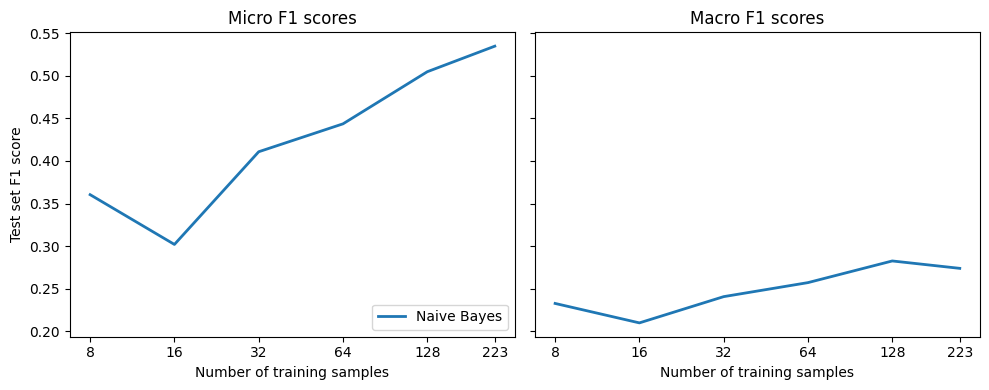

In [62]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

Note that we plot the number of samples on a logarithmic scale. From the figure we can see that the micro and macro F1 scores both improve as we increase the number of training samples. With so few samples to train on, the results are also slightly noisy since each slice can have a different class distribution. Nevertheless, what's important here is the trend, so let's now see how these results fare agains transformer-based approaches!

## 3 - Working with no labeled data

The first technique that we'll consider is *zero-shot classification*, which is suitablein settings where you have no labeled data at all. This is surpresingly common in industry, and might occur because there is no historic data with labels or because acquiring the labels for the data is difficult. We will cheat a bit in this section since we will still use the test data to measure the performance, but we will not use any data to train the model (otherwise the comparison to the following approaches would be difficult).

The goal of zero-shot classification is to make use of a pretrained model without any additional fine-tuning on your task-specific corpus. To get a better idea of how this could work, recall that language models like BERT are pretrained to predict masked tokens in text on thousands of books and large Wikipedia dumps. To successfully predict a missing token, the model needs to be aware of the topic in the context. We can try to trick the model into classifying a document for us by providing a sentence like:

`This section was about the topic [MASK]`

The model should then give a reasonable suggestion for the document's topic, since this is a natural text to occur in the dataset.

Let's illustrate this further with the following toy problem: suppose you have two children, and one of them likes movies with cars while the other enjoys movies with animals better. Unfortunately, they have already seen all the ones you know, so you want to build a function that tells you what topic a new movie is about. Naturally, you turn to transformers for this task. The first thing to try is to load BERT-base in the `fill-mask` pipeline, which uses the masked language model to predict the content of the masked tokens:

In [63]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Next, let's construct a little movie description and add a prompt to it with a masked word. The goal of the prompt is to guide the model to help us make a classification. The `fill-mask` pipeline returns the most likely tokens to fill in the masket spot:

In [65]:
movie_desc = "The main characters of the movie madagascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."
output = pipe(movie_desc + prompt)

for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token madagascar:	0.425%
Token animals:	0.084%
Token sharks:	0.054%
Token lions:	0.037%
Token penguins:	0.032%


----

**Note from 10/2023:** This approach is a bit outdated given the current use of GPT-3 and Langchain. GPT-3 with a proper prompt would give better results while being easy to use too.

----